In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random 
import openpyxl

plt.rcParams["font.family"] = "Helvetica"

/Users/rciez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# calculating emissions from steel
colors = [[.61, .27, .54], [.86, .73, .29]]
def green_steel_pathway(pathway): #instantaneous, 10-year
    x = np.zeros(26); gs = np.zeros(26); rs = np.zeros(26)
    for n in range(26):
        start_steel = 14814505*1.005*1.005*1.005 #what was produced in 2022 inflated to 2025 estimate 
        growth_steel = 1.0005
        elec_per_unit_steel = 4.27 
        y = 2025+n
        if pathway == 'instantaneous':
            gs[n] = start_steel * (growth_steel**n)
            rs[n] = 0
            x[n] = start_steel * (growth_steel**n)*elec_per_unit_steel/8760
        else:
            if n < 10:
                gs[n] = start_steel * (growth_steel**n) * (n+1)/11
                rs[n] = start_steel * (growth_steel**n) * (1-((n+1)/11))
                x[n] = gs[n] * elec_per_unit_steel/8760
            else:
                gs[n] = start_steel * (growth_steel**n)
                x[n] = start_steel * (growth_steel**n)*elec_per_unit_steel/8760
                rs[n] = 0
    
    x2 = [x[0], x[5], x[10], x[15], x[20], x[25]]
    return(x2, gs, rs)

In [5]:
def plotNscenarios_avoided_montecarlo(cases, legend, plottitle, regions, elecprocess, bauprocess, axlims):
    fig, axes = plt.subplots(1, 3, figsize = (7,4.5))
    numsims = 5
    avoidedemissions = np.zeros((len(cases), numsims, 6))
    cumulativeAvoidedEmissions = np.zeros((len(cases),numsims, 26))
    cumulativeEmissions = np.zeros((len(cases), numsims, 26))
    cumulative_original_emissions = np.zeros((numsims, 26))
    for m in range(numsims): #monte carlo stuff
        if m == 0:
            bau_value = bauprocess[0]
            eaf_value = elecprocess[0]
        else:
            bau_value = random.uniform(bauprocess[1], bauprocess[2])
            eaf_value = random.uniform(elecprocess[1], elecprocess[2])
        or_emit = (gs+rs)*bau_value
        original_emissions = or_emit[[0,5,10,15,20,25]]
        cumulative_original_emissions[m,:] = np.cumsum(or_emit) #don't think this gets used later
        for q in range(len(cases)):
            x = 0
            gen1 = pd.read_excel('combined_gen_ann.xlsx', sheet_name=cases[q])
            gen1 = gen1.loc[gen1['r'].isin(regions)]
            gen1s = gen1.groupby(['t']).sum()
            emit1 = pd.read_excel('combined_emit.xlsx', sheet_name = cases[q])
            emit1 = emit1.loc[emit1['r'].isin(regions)]
            emit1 = emit1.loc[emit1['eall']=='CO2e']
            emit1s = emit1.groupby(['t']).sum()
            emitrate1 = emit1s.Val/gen1s.Val
            steelelecemissions1 = emitrate1[-6:]*x2*8760
            steelprocessemissions = eaf_value*gs + bau_value*rs
            spr = steelprocessemissions[[0,5,10,15,20,25]]
            totalemissions = steelelecemissions1 + spr
            avoidedemissions[q, m, :] = original_emissions - totalemissions 
            for n in range(26):
                if n == 0: 
                    cumulativeAvoidedEmissions[q,m,n] = avoidedemissions[q,m,int(x)] 
                    cumulativeEmissions[q,m,n] = totalemissions.values[x]
                    x = x+1
                elif n%5 == 0:
                    cumulativeAvoidedEmissions[q,m,n] = cumulativeAvoidedEmissions[q,m,n-1] + avoidedemissions[q,m,int(x)]
                    cumulativeEmissions[q,m,n] = cumulativeEmissions[q,m,n-1] + totalemissions.values[x]
                    x = x+1
                else:
                    cumulativeAvoidedEmissions[q,m,n] = cumulativeAvoidedEmissions[q,m, n-1] + avoidedemissions[q,m, int(x-1)] + (n%5)*(avoidedemissions[q,m, int(x)]-avoidedemissions[q,m, int(x-1)])/5
                    cumulativeEmissions[q,m,n] = cumulativeEmissions[q,m, n-1] + totalemissions.values[x-1]+(n%5)*(totalemissions.values[x]-totalemissions.values[x-1])/5
    
    # pull median, and 95% confidence interval results and make a plot 
    for q in range(len(cases)):
        axes[0].plot([2025, 2030, 2035, 2040, 2045, 2050], avoidedemissions[q, 0, :]/1000000)
        axes[0].fill_between([2025, 2030, 2035, 2040, 2045, 2050], np.percentile(avoidedemissions, 2.5, axis = 1)[q,:]/1000000, np.percentile(avoidedemissions, 97.5, axis = 1)[q,:]/1000000, alpha = 0.3)
        axes[1].plot(np.linspace(2025, 2050, 26), cumulativeAvoidedEmissions[q, 0, :]/1000000)
        axes[1].fill_between(np.linspace(2025, 2050, 26), np.percentile(cumulativeAvoidedEmissions, 2.5, axis = 1)[q,:]/1000000, np.percentile(cumulativeAvoidedEmissions, 97.5, axis = 1)[q,:]/1000000, alpha = 0.3)
        axes[2].plot(np.linspace(2025, 2050, 26), cumulativeEmissions[q, 0, :]/1000000)
        axes[2].fill_between(np.linspace(2025, 2050, 26), np.percentile(cumulativeEmissions, 2.5, axis = 1)[q,:]/1000000, np.percentile(cumulativeEmissions, 97.5, axis = 1)[q,:]/1000000, alpha = 0.3)
    axes[2].plot(np.linspace(2025, 2050, 26), cumulative_original_emissions[0,:]/1000000)
    axes[2].fill_between(np.linspace(2025, 2050, 26), np.percentile(cumulative_original_emissions, 2.5, axis = 0)/1000000, np.percentile(cumulative_original_emissions, 97.5, axis = 0)/1000000, alpha = 0.3)    
    axes[0].legend(legend, fontsize = 9, loc = 'lower right') 
    axes[1].legend(legend, fontsize = 9, loc = 'upper left')
    L = legend.copy()
    L.extend(["BOF"])
    axes[2].legend(L, fontsize = 9, loc = 'upper left')
    axes[0].set_ylabel('Annual Avoided Emissions (CO$_{2e}$ [million metric tons])', fontsize = 9)
    axes[1].set_ylabel('Cumulative Avoided Emissions (CO$_{2e}$ [million metric tons])', fontsize = 9)
    axes[2].set_ylabel('Cumulative Total Emissions (CO$_{2e}$ [million metric tons])', fontsize = 9, fontname = 'Helvetica')
    axes[1].set_xlabel('Year', fontsize = 9)
    if axlims == 'main':
        axes[0].set_ylim(-15, 30)
        axes[0].text(2048, -15+(30+15)*.95, '(a)', fontsize = 9, horizontalalignment = 'center')
        axes[1].set_ylim(-100, 650)
        axes[1].text(2048, -100+750*.95, '(b)', fontsize = 9, horizontalalignment = 'center')
    else: 
        axes[0].set_ylim(-20, 30)
        axes[0].text(2048, -20+(30+20)*.95, '(a)', fontsize = 9, horizontalalignment = 'center')
        axes[1].set_ylim(-110, 650)
        axes[1].text(2048, -110+760*.95, '(b)', fontsize = 9, horizontalalignment = 'center')
    axes[2].set_ylim(-10, 850)
    axes[2].text(2048, -10+860*.95, '(c)', fontsize = 9, horizontalalignment = 'center')
    fig.suptitle(plottitle)
    plt.tight_layout()
    plt.savefig('EmissionsFigures/avoidedemissions_montecarlo'+plottitle+'.png', dpi = 300)
    plt.show()

Baseline, 10 year transition, Indiana balacing areas only

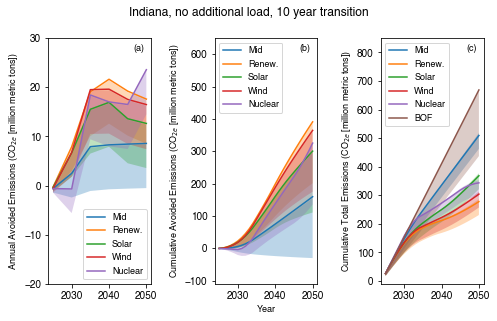

In [6]:
x2, gs, rs = green_steel_pathway('10yr') #generate the steel transition profile 
caselist = ['mid', 'renew', 'solar', 'wind', 'nuke']
cases = ['base' + s for s in caselist] 
    # base = no change in load profile 
    # alternatives to 'base' are 'med10' for a median energy consumption
    # medInst for a median energy consumption and instantaneous transition
    # prct10yr for a 98th percentile energy consumption and a 10 year steel transition
    # prctInst for a 98th percentile energy consumption and an instantaneous steel transition 
legend = ['Mid', 'Renew.', 'Solar', 'Wind', 'Nuclear']
regions = ['p105', 'p106', 'p107'] #Indiana grid balancing areas only 
plottitle = ('Indiana, no additional load, 10 year transition')
elecprocess = [0.0675, 0.022, 0.1599] #based on our calculations
bauprocess = [1.7, 1.1, 2.1] #based on EPA reported data
plotNscenarios_avoided_montecarlo(cases, legend, plottitle, regions, elecprocess, bauprocess, 'SI')

Baseline, 10 year transition, MISO balacing areas

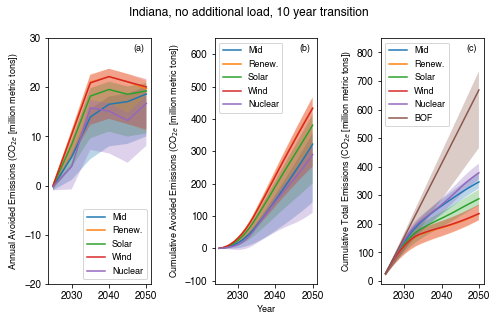

In [7]:
x2, gs, rs = green_steel_pathway('10yr') #generate the steel transition profile 
caselist = ['mid', 'renew', 'solar', 'wind', 'nuke']
cases = ['base' + s for s in caselist] 
legend = ['Mid', 'Renew.', 'Solar', 'Wind', 'Nuclear']
hier = pd.read_csv('inputs/hierarchy.csv') #input from ReEDs model: https://github.com/NREL/ReEDS-2.0/blob/main/inputs/hierarchy.csv
hier = hier.loc[hier['nercr']=='MISO']
regions = list(hier['*r'])
plottitle = ('Indiana, no additional load, 10 year transition')
elecprocess = [0.0675, 0.022, 0.1599] #based on our calculations
bauprocess = [1.7, 1.1, 2.1] #based on EPA reported data
plotNscenarios_avoided_montecarlo(cases, legend, plottitle, regions, elecprocess, bauprocess, 'SI')